# Introduction

This project was done as the final project for the Advanced Machine Learning Course of [Suven Consultants](https://datascience.suvenconsultants.com/) under the mentorship of [Mr. Rocky Jigtiani](https://www.linkedin.com/today/author/rocky-jagtiani-3b390649/).

In this course we, learned about various advance machine learning concepts like text classification,sentiment analysis,information retrieval,text summarization,speech recognition,text-to-speech,speech-to-text,next word prediction,languge translation and detection,etc.

Based on these concepts and using data given [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/), we were asked to create a project for completion of our course.

I would like to thank Mr. Rocky Jagtiani Sir and my partner [Chetan Gadge](https://www.linkedin.com/in/chetan-gadge-7b1090189/) for helping me with this project.


Based on data we thought of two problem statements:

> Problem Statement 1: Prediction of Helpfulness from given data.

> Problem Statement 2: Classification of genuine and fake/sarcastic reviews.

Data Preparation
--

Before we start with the problem statements, we have to do a little data preparation.

First, let's import all required files.

In [1]:
# Importing the required files.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import string
from time import time
import nltk
from nltk.corpus import stopwords 
stops = set(stopwords.words("english"))
import re
from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
RAN_STATE = 42 # Setting the random state

We will now import the dataset and extract data.

The dataset has been taken from [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/) and doesn't belong to me.

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-electronics-reviews/Electronics_5.json


We will now read the data.

The dataset is a JSON file so we are using the read_json() function of Pandas. We have used *lines=True*  to read the file as a JSON object per line, else it will give an error.

For more information,see [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html)

In [3]:
# Read json data
data=pd.read_json('/kaggle/input/amazon-electronics-reviews/Electronics_5.json',lines=True,orient='columns')
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


Since our reviews may also contain duplicates, we are using the drop_duplicate() function to remove duplicates.
For more info,see [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html).

In [4]:
# Remove duplicate reviews(if any)
print("The shape of the data set before removing duplicate reviews : {}".format(data.shape))
data=data.drop_duplicates(subset=["reviewText"], keep='first', inplace=False)
print("The shape of the data set after removing duplicate reviews : {}".format(data.shape))

The shape of the data set before removing duplicate reviews : (1689188, 9)
The shape of the data set after removing duplicate reviews : (1687169, 9)


As we can see, our data did have duplicate reviews. Now let's go-to text preprocessing.

Text Preprocessing
--

Since we are having two problem statements, both of which require the same kind of preprocessing, we are going to preprocess before starting with the problem statements.

Preprocessing before going to problem statements will save a lot of time since just to preprocess once, I required about an hour.

In [5]:
def preprocess(x):
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because").replace("i'm"," i am")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x=re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))',' ',x)
    x=re.sub(r"\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',x)
    x=re.sub(r'<.*?>',' ',x)
    x=re.sub('[^a-zA-Z]',' ',x)
    x=''.join([i for i in x if not i.isdigit()])
    return x

Here we are going to first convert reviews to lowercase. Then we are going to do preprocessing. And finally, go to lemmatization.

Here we could also use stemming but I am going to use lemmatization.

> **Stemming:** Stemming is a process of extracting a root word. For example, “fish,” “fishes,” and “fishing” are stemmed into fish.
> 
> **Lemmatization:** Lemmatization is a process of extracting a root word by considering the vocabulary. For example, “good,” “better,” or “best” is lemmatized into good. The part of speech of a word is determined in lemmatization. It will return the dictionary form of a word, which must be valid while stemming just extracts the root word.

*Lemmatization handles matching “car” to “cars” along with matching “car” to “automobile.”*

*Stemming handles matching “car” to “cars.”*

For more info see [here](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

In [6]:
# Import libraries
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

# Lower casing and removing punctuations
data['reviewText'] = data['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['reviewText'] = data['reviewText'].str.replace('[^\w\s]','')

# Removing stopwords
#stop = stopwords.words('english')
#data['reviewText'] = data['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['reviewText'] = data['reviewText'].apply(lambda x: preprocess(x))
# Lemmatization

data['reviewText'] = data['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data.reviewText.head(5)

0    we got this gps for my husband who is an otr o...
1    im a professional otr truck driver and i bough...
2    well what can i say ive had this unit in my tr...
3    not going to write a long review even thought ...
4    ive had mine for a year and here what we got i...
Name: reviewText, dtype: object

Now, let's start with problem statements.

# Problem Statement 1

A Rough Overview
--
Marketing is an essential part of the business. 
Digital marketing was already in hype for the past few years, but due to this pandemic, it has increased exponentially. 
Since a customer cannot physically check the product, he/she has to depend on reviews of the given product. 

Amazon has a helpfulness rating system, that allows users to see top-rated reviews which can help a customer to make an informed decision. 

But even if this helps, poor-quality reviews can still come on top of forums.

Having poor quality reviews displayed in forums hurts Amazon’s business since the major reason as stated above is that people are willing to buy consumer goods online without seeing the items themselves because they have access to other people's opinions of the item. 

Problem Statement
--
The problem addressed here is Amazon Reviews of poor quality that are there, at the top of forums despite the helpfulness rating system of Amazon. 
This problem mainly arises due to the new reviews are directly placed on top of the forum which would give the community a chance to rate them.

The solution to this problem is to create a model using machine learning techniques that would pre-rate the helpfulness of a given customer review before they are posted on the top of the forum. 
This way poor quality reviews would not be shown on top of forums.

The model will be trained on Amazon Reviews for Electronic Category to predict if a given review is helpful or not helpful.

Let's see the given data.

In [7]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",we got this gps for my husband who is an otr o...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]",im a professional otr truck driver and i bough...,1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]",well what can i say ive had this unit in my tr...,3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]",not going to write a long review even thought ...,2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",ive had mine for a year and here what we got i...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


**Based on the above data we can say:**
> Input Features : reviewText,overall

> Output labels: helpfulness

**Reason for selecting input features:** When we give any review, along with text(reviewText) of the review we also give a rating in stars(overall).

**A brief explanation about the helpful column:** helpful column given above is a list containing two values---no of helpful ratings and the total no of ratings--- separated by a comma.

We are dividing the helpful column into two parts i.e. 
 
 > helpful_numerator => contains no. of helpful rating.
 
 > helpful_denominator => contains total no. of ratings.

and then we are deleting the helpful column.


In [8]:
#select the columns
df = data.iloc[:, [5,4,3]]

#split numerator and denominator
df['helpful_numerator'] = df['helpful'].apply(lambda x: x[0])
df['helpful_denominator'] = df['helpful'].apply(lambda x: x[1])

# delete un-needed helpful column
del df['helpful']

#Check if we have any null values
print (df.isnull().sum())

overall                0
reviewText             0
helpful_numerator      0
helpful_denominator    0
dtype: int64


Let's see some stats.

In [9]:
df.describe()

,overall,helpful_numerator,helpful_denominator
count,1.687169e+06,1.687169e+06,1.687169e+06
mean,4.222604e+00,3.129790e+00,3.747861e+00
std,1.185743e+00,3.865623e+01,4.035785e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,2.000000e+00
max,5.000000e+00,3.073500e+04,3.145300e+04


Here, since our dataset is huge(about 1687169 records), we are taking only those records that have at least 20 ratings in total.

In [10]:
# include reviews that have more than 20 helpfulness data point only
df1 = df[(df.helpful_denominator > 20)].copy()
df1.shape

(50185, 4)

Here to get our output label **helpfulness**, we have to take the ratio of helpful_numerator to helpful_denominator. The result is compared with a threshold value(*we are taking threshold as 50%, but we can change it as per our requirement*).
* If result > threshold ==> helpful = 1
* if result < treshold ==> not helpful = 0

In [11]:
# transform Helpfulness into a binary variable with 0.5 ratio
threshold = 0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_numerator'] \
                                 / df1.loc[:, 'helpful_denominator'] > threshold, 1, 0)
df1.head(3)

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
2,3,well what can i say ive had this unit in my tr...,43,45,1
211,3,i purchased this mount for my inch lcd tv inst...,70,92,1
221,5,do not listen to other reviewer screw that thi...,18,23,1


Now let's do the count of data to get an idea about the distribution of helpfulness.

In [12]:
#Check the balance
print ('Count:')
display(df1.groupby('Helpful').count())

Count:


,overall,reviewText,helpful_numerator,helpful_denominator
Helpful,,,,
0,4896,4896,4896,4896
1,45289,45289,45289,45289


Now let's see the whole data since we are going to creating our model.

In [13]:
df1

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
2,3,well what can i say ive had this unit in my tr...,43,45,1
211,3,i purchased this mount for my inch lcd tv inst...,70,92,1
221,5,do not listen to other reviewer screw that thi...,18,23,1
263,5,the nook tablet is a solid hybrid tabletebook ...,33,39,1
273,1,update sep put on cm android last week ive got...,52,57,1
...,...,...,...,...,...
1689042,5,to put it in perspective for people who say it...,20,21,1
1689045,3,suck that id have to buy a whole new motherboa...,5,63,0
1689071,5,yes usd seems to be a very big amount for rout...,11,21,1
1689082,5,wow after year of fighting weak wifi really ye...,28,32,1


Since we have already prepared the data above. We are now directly applying TF-IDF Vectorizer to generate more features.
TF-IDF is an acronym of Term Frequency Inverse Document Frequency. It is a statistical measure used to find how important a word is to document in a collection or corpus. It is generally used in text mining and information retrieval.

> TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it may possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:
>  
> TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).
>  
> IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However, it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scaling up the rare ones, by computing the following:
>  
> IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

To get more information about TF-IDF see [here](http://www.tfidf.com/).

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# define the vectorizer
vectorizer = TfidfVectorizer(min_df = 0.01)
# fit the vectorizers to the data.
features = vectorizer.fit_transform(df1['reviewText'])
features

<50185x2232 sparse matrix of type '<class 'numpy.float64'>'
	with 7272025 stored elements in Compressed Sparse Row format>

Since we don't have a separate dataset for testing we are splitting data as 80% for training and 20% for testing.

In [15]:
# split and shuffle data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

Since our problem is of binary classification(helpful or not helpful), we are using roc_auc_score to evaluate our model.

The roc_auc_score computes the area under the receiver operating characteristic (ROC) curve which is also denoted by AUC or AUROC. By computing the area under the roc curve, the curve information is summarized in one number.

This curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR). The area under the curve is used to give a score to the model.
> If AUC = 0.5 => TPR = FPR, and the model is doing just random computations.
>
> If AUC= 1.0 => TPR = 100%,and it is an ideal model.

* True Positive: the truth is positive, and the test predicts a positive. e.g. The person is sick, and the test accurately reports this.
* False Positive: the truth is negative, but the test predicts a positive. e.g. The person is not sick, but the test inaccurately reports that they are. It is also called a Type I error in statistics.

For more information about roc_auc_score,see [here](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).


In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

To make a baseline model for our project we are going to use the following algorithms :

* **GaussianNB**: GaussianNB implements the Gaussian Naive Bayes algorithm for classification. In Gaussian Naive Bayes, continuous values associated with each feature are assumed to be distributed according to a Gaussian distribution. 
A Gaussian distribution is also called Normal distribution. When plotted, it gives a bell-shaped curve that is symmetric about the mean of the feature values.
<img src="https://imgur.com/nMRnwlL.png" width="400px">

* **Logistic Regression**: Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt), or the log-linear classifier

* **Decision tree**: DecisionTreeClassifier is a classifier capable of performing both binary and multi-class classification on a dataset. A Decision tree is a flowchart-like tree structure, where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label.

All the algorithms used here are popular algorithms for classification. However, since we are doing binary classification, I think *Logistic Regression* would give better results than *Decision tree* or *Gaussian Naive Bayes*.

For more information, see [here](https://scikit-learn.org/stable/supervised_learning.html).

In [17]:
# Import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(),  
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]
x_tr = X_train.toarray()
x_te = X_test.toarray()


# Set up the training set sizes for 10000, 20000 and 40000 respectively.
train_feature_list = [x_tr[0:10000],x_tr[0:20000],x_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)

Training a GaussianNB using a training set size of 10000. . .
Trained model in 0.4789 seconds
Made predictions in 0.3991 seconds.
ROC_AUC score for training set: 0.8883.
Made predictions in 0.3960 seconds.
ROC_AUC score for test set: 0.6976.

Training a GaussianNB using a training set size of 20000. . .
Trained model in 0.8088 seconds
Made predictions in 0.7625 seconds.
ROC_AUC score for training set: 0.8468.
Made predictions in 0.3878 seconds.
ROC_AUC score for test set: 0.7139.

Training a GaussianNB using a training set size of 40148. . .
Trained model in 1.5891 seconds
Made predictions in 1.5365 seconds.
ROC_AUC score for training set: 0.8198.
Made predictions in 0.3882 seconds.
ROC_AUC score for test set: 0.7447.

Training a LogisticRegression using a training set size of 10000. . .
Trained model in 3.9958 seconds
Made predictions in 0.0597 seconds.
ROC_AUC score for training set: 0.9187.
Made predictions in 0.0601 seconds.
ROC_AUC score for test set: 0.8564.

Training a LogisticR

It's a hassle to find each value. So let's just visualize the outputs for all models.

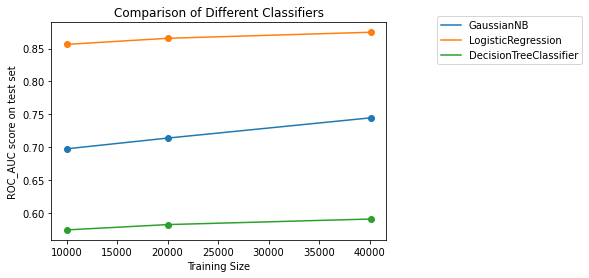

<Figure size 1008x576 with 0 Axes>

In [18]:
FIG_SIZE = (14,8)
# Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show() 

Just as we thought Logistic Regression gives us the best accuracy. Its final score for the area under the ROC curve was 0.8704 and a sample size of ~40,000. Besides, it is the fastest. The training speed and prediction speed were 19.993s and 0.955s  for a sample size of 40,000. Since our model has to consider the accuracy and speed, the Logistic Regression algorithm represents the ideal model for us.

Now, let's add values of scores to the review text and see if we can increase the accuracy of our model.

In [19]:
#add Score column to features
import scipy as scipy

overall = np.array(list(df1.overall))
overall = overall.reshape(features.shape[0], 1)

features = scipy.sparse.hstack((features,scipy.sparse.csr_matrix(overall)))

features = scipy.sparse.csr_matrix(features)
features


<50185x2233 sparse matrix of type '<class 'numpy.float64'>'
	with 7322210 stored elements in Compressed Sparse Row format>

We can now split the dataset and try to optimize our initial model.

In [20]:
X_train2, X_test2, y_train, y_test = train_test_split(features, df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

Hyper-parameters are parameters that are not directly learned within estimators. In scikit-learn, they are passed as arguments to the constructor of the estimator classes. Hyperparameter tuning helps us in optimizing our model.
For more information see [here](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

We will now be applying Gridsearch and Cross-Validation techniques to optimize and hypertune our model.

* **GridSearch:** Exhaustive search over specified parameter values for an estimator.

* **Cross-Validation:** In the train-test split, we use only 20% for testing. The performance metric we get on that 20% test data may not be accurate. So Cross-Validation allows you to consume 100% of the data for training and testing both.
 
For more information see [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)

In [21]:
from sklearn.model_selection import GridSearchCV,cross_validate,StratifiedKFold
#make the grid search object
gs2 = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,5)], 'class_weight': [None, 'balanced']},
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc'
)

#fit the grid search object to our new dataset
print ('Fitting grid search...')
gs2.fit(X_train2, y_train)
print ("Grid search fitted.")

Fitting grid search...
Grid search fitted.


Let's the best estimator for our model.

In [22]:
#print the grid search scores.
gs2.best_params_

{'C': 1, 'class_weight': None}

We can see our optimized classifier is a LogisticRession with a 'C' parameter of 1 and a 'class_weight' = 'None'. This is the same as default, meaning our optimization step did not change the parameters of our model. Let's now find our ROC_AUC Score.

In [23]:
clf2 = gs2.best_estimator_
probas =clf2.predict_proba(X_test2)


# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))

ROC_AUC Score: 0.9044752402751628


Wow! 90 % ROC_AUC Score. That means our model has been trained well.

Let's now plot the graph to find the ROC Curve for Helpful Rating of both TFIDF and TFIDF along with the overall score. 

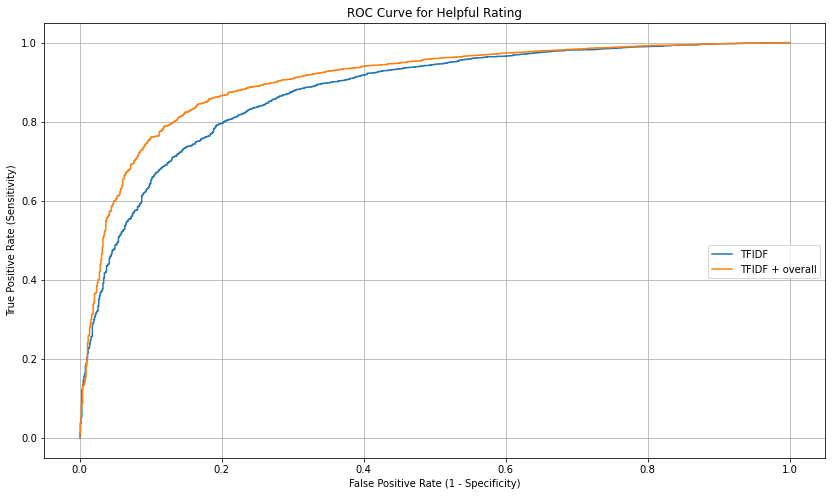

<Figure size 1008x576 with 0 Axes>

In [24]:

clf = LogisticRegression()
clf.fit(X_train,y_train)
probas = clf.predict_proba(X_test)
clf2 = gs2.best_estimator_
probas2 =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)

# plot graph to show roc_auc_score.
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label = 'TFIDF')
plt.plot(roc_curve(y_test, probas2[:,1])[0], roc_curve(y_test, probas2[:,1])[1], label = 'TFIDF + overall')
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.legend(bbox_to_anchor=(1.0, .5))
plt.figure(figsize=FIG_SIZE)
plt.show()

As we can see in the above ROC Curve, adding an overall score to TFIDF vectors would give us a higher Area Under Curve(AUC).

Conclusion:
--
The important quality of this problem statement is the effect of introducing a new key feature to our model. Here, we mainly looked at the TFIDF features generated from Amazon's Electronic Reviews text and added the 'overall_rating' (star rating) that was given to the product by the reviewer. We used these features to predict how 'helpful' other users would find the review.

# Problem Statement 2

A Rough Overview
--
Marketing is an essential part of the business. Digital marketing was already in hype for the past few years but due to this pandemic, it has increased exponentially. Since a customer cannot physically check the product, he/she has to depend on reviews of the given product. 

Despite this there are some people who do not give genuine review or give a sarcastic review.

Here are some examples:

<img src="https://imgur.com/Dbxy4Ck.jpeg" width="400px">

<img src="https://imgur.com/QWuvHhN.jpeg" width="400px">

Having such reviews displayed in forums hurts Amazon’s business since the major reason as stated above is that people are willing to buy consumer goods online without seeing the items themselves because they have access to other people's opinions of the item. 

Problem Statement
--
The problem that is being addressed here is if Amazon Review is fake or not genuine. Sometimes some people give fake reviews on forums. This could harm the sale of the product if such a review came on top. 

By fake review I mean which is given a 5-star rating but in review text, the person gives a negative review and since it is rated 5 stars, so chances are that review would come on top of the forum. 

The possibility exists that such reviews be given by competitors to harm the sale of the product.

The solution to this problem is to create a model using machine learning techniques that would classify given customer reviews based on sentiment analysis before they are posted on the top of the forum. This way fake reviews would not be shown on top of forums.

The model will be trained on Amazon Reviews for Electronic Category to classify if a given review is genuine or not.

Let's see the given data.

In [25]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",we got this gps for my husband who is an otr o...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]",im a professional otr truck driver and i bough...,1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]",well what can i say ive had this unit in my tr...,3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]",not going to write a long review even thought ...,2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",ive had mine for a year and here what we got i...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


Here, we are going to select **reviewText** and **overall** score rating since we going to classify reviews based on these two features.

In [26]:
#select the columns
df2 = data.iloc[:, [5,4]]
df2.head(10)

,overall,reviewText
0,5,we got this gps for my husband who is an otr o...
1,1,im a professional otr truck driver and i bough...
2,3,well what can i say ive had this unit in my tr...
3,2,not going to write a long review even thought ...
4,1,ive had mine for a year and here what we got i...
5,5,i am using this with a nook hd it work a descr...
6,2,the cable is very wobbly and sometimes disconn...
7,5,this adaptor is real easy to setup and use rig...
8,4,this adapter easily connects my nook hd to my ...
9,5,this product really work great but i found the...


Now let's first classify score ratings as Positive, Negative, and Neutral.

> * If the **score rating => 4 or 5**,we are taking it as **Positive**.
>
> * If the **score rating => 3**,we are taking it as **Neutral**.
>
> * And if the **score rating => 1 or 2**,we are taking it as **Negative**.

Then we are saving the result in a column named **Overall_Sentiment**. This would tell us the sentiment of the review based on the star rating.

In [27]:
def score_classify(x):
    if x>3:
        return 'Positive'
    elif x<3:
        return 'Negative'
    else:
        return 'Neutral'
df2['Overall_Sentiment']=df2.apply(lambda x: score_classify(x['overall']),axis=1)
df2

,overall,reviewText,Overall_Sentiment
0,5,we got this gps for my husband who is an otr o...,Positive
1,1,im a professional otr truck driver and i bough...,Negative
2,3,well what can i say ive had this unit in my tr...,Neutral
3,2,not going to write a long review even thought ...,Negative
4,1,ive had mine for a year and here what we got i...,Negative
...,...,...,...
1689183,5,burned these in before listening to them for a...,Positive
1689184,5,some people like dj style headphone or earbud ...,Positive
1689185,5,i m a big fan of the brainwavz s actually all ...,Positive
1689186,5,ive used thebrainwavz s in ear headphone and t...,Positive


Now, let's find out how the number of Positive, Negative, and Neutral reviews.

In [28]:
df2.Overall_Sentiment.value_counts()

Positive    1354351
Negative     190693
Neutral      142125
Name: Overall_Sentiment, dtype: int64

Here we can see that 1354351 reviews are Positive,190693 are Negative while 142125 are Neutral.

But it may also be possible that some data may be missing or null. 

So let's drop null values if there are any. Then recheck the number of reviews.

In [29]:
df2.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)
df2.Overall_Sentiment.value_counts()

Positive    1354351
Negative     190693
Neutral      142125
Name: Overall_Sentiment, dtype: int64

So we can see that there are no missing or null values.

Let's now go for sentiment analysis of review text.

Sentiment analysis is a process in which we computationally analyze and identify opinions and judgments of a customer from a piece of text. You can understand if a piece of text is positive, negative, or neutral, based on their sentiment analysis.

There are various types of sentiment analysis, but we are using aspect-based sentiment analysis here.

Aspect-based sentiment analysis is generally for one or more aspects of a service or product. 

For example, if a company that sells mobile phones uses this type of sentiment analysis, it could be for one aspect of mobile phones – like battery life, processor, USF storage, etc. 

So they can understand how customers feel about specific attributes of the product. 

For more information, see [here](https://www.upgrad.com/blog/types-of-sentiment-analysis/).

We can implement aspect-based sentiment analysis in different ways. 

The most famous is Sentiment Intensity Analyzer(commonly known as SIA) from vaderSentiment. 

But I found that sentiment from Textblob gives better results than SIA here. So we have used the sentiment from Textblob.

For more information see [here](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis).

In [30]:
from textblob import TextBlob

sentiment_score_list = []
sentiment_label_list = []

for i in df2['reviewText'].values.tolist():
    sentiment_text=TextBlob(i)
    sentiment_score = sentiment_text.sentiment.polarity
    #print(sentiment_score)

    if sentiment_score > 0:
        sentiment_score_list.append(sentiment_score)
        sentiment_label_list.append('Positive')
    elif sentiment_score < 0:
        sentiment_score_list.append(sentiment_score)
        sentiment_label_list.append('Negative')
    else:
        sentiment_score_list.append(sentiment_score)
        sentiment_label_list.append('Neutral')
    
df2['Review_Sentiment'] = sentiment_label_list
df2['sentiment score'] = sentiment_score_list

display(df2.head(10))

,overall,reviewText,Overall_Sentiment,Review_Sentiment,sentiment score
0,5,we got this gps for my husband who is an otr o...,Positive,Positive,0.250000
1,1,im a professional otr truck driver and i bough...,Negative,Positive,0.062441
2,3,well what can i say ive had this unit in my tr...,Neutral,Positive,0.086977
3,2,not going to write a long review even thought ...,Negative,Positive,0.047284
4,1,ive had mine for a year and here what we got i...,Negative,Positive,0.002778
5,5,i am using this with a nook hd it work a descr...,Positive,Positive,1.000000
6,2,the cable is very wobbly and sometimes disconn...,Negative,Negative,-0.100000
7,5,this adaptor is real easy to setup and use rig...,Positive,Positive,0.274439
8,4,this adapter easily connects my nook hd to my ...,Positive,Positive,0.297718
9,5,this product really work great but i found the...,Positive,Positive,0.212487


We can see that some reviews are of Neutral, sentiment based on star rating bit are Positive, based on the sentiment of review text.

Such reviews may be harmful to our model as they could be classified wrongly.

So we are removing all Neutral reviews.

In [31]:
before=df2.shape[0]
df2 = df2[df2.Overall_Sentiment != 'Neutral']
df2 = df2[df2.Review_Sentiment != 'Neutral']
df2.head(10)
after=df2.shape[0]
#EDA for finding how many neutral labels have been removed

Now let's find out how many Neutral reviews we have removed.

In [32]:
print("The number of neutral labels have been removed : {}".format(before-after))

The number of neutral labels have been removed : 176941


Wow! That is a lot of reviews.

Now, let's classify reviews as true or false.

The true review would one in which the sentiment of star rating matches the sentiment of review text.

 If it does not match, then we could say that review is false.

In [33]:
comparison_column = np.where(df2["Overall_Sentiment"] == df2["Review_Sentiment"], True, False)
df2["result"] = comparison_column
df2.head()

,overall,reviewText,Overall_Sentiment,Review_Sentiment,sentiment score,result
0,5,we got this gps for my husband who is an otr o...,Positive,Positive,0.250000,True
1,1,im a professional otr truck driver and i bough...,Negative,Positive,0.062441,False
3,2,not going to write a long review even thought ...,Negative,Positive,0.047284,False
4,1,ive had mine for a year and here what we got i...,Negative,Positive,0.002778,False
5,5,i am using this with a nook hd it work a descr...,Positive,Positive,1.000000,True


Now, let's find the total number of all the fake reviews. 

And also see some as an example.

In [34]:
df2 = df2[df2.result != True]
print(df2.shape)
df2.head()

(202988, 6)


,overall,reviewText,Overall_Sentiment,Review_Sentiment,sentiment score,result
1,1,im a professional otr truck driver and i bough...,Negative,Positive,0.062441,False
3,2,not going to write a long review even thought ...,Negative,Positive,0.047284,False
4,1,ive had mine for a year and here what we got i...,Negative,Positive,0.002778,False
22,4,this wall mount doe everything it supposed to ...,Positive,Negative,-0.092143,False
36,5,didnt think it would work a well a it hasbecau...,Positive,Negative,-0.063889,False


Finally, we found all the reviews that are not genuine and that is a lot of reviews.

Conclusion:
--
The importance of this problem statement is that we can easily find out if the given review is genuine or not. 
Here, we used review text and star rating from Amazon's Electronic Reviews that was given to the product by the reviewer. We used these features to classify if the given review is truly genuine or not.

# Conclusion of Project

In this project, we first predicted the helpfulness of review. In the second part, we found out about the genuinity of reviews.

For the second part, I have also made a web app using streamlit in which you can find out find if the review is genuine or not.

**Click [here](https://share.streamlit.io/letus21500/amazon-electronic-reviews/main/amazon.py) to go to the web app.**

**Github link is given [here](https://github.com/letus21500/Amazon-Electronic-Reviews).**

I would like to thank [Rocky Jigtiani Sir](https://www.linkedin.com/today/author/rocky-jagtiani-3b390649/) for guiding me in this project. 

I would also like to thank my friend and project-partner [Chetan Gadge](https://www.linkedin.com/in/chetan-gadge-7b1090189/) for helping me with this project.